### Import packages

In [1]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'svg'

%matplotlib widget
%load_ext autoreload
%autoreload 2

### Load neural and behavioral data

In [2]:
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

### Make design matrix

In [3]:
def make_design_matrix(trial_ts, spike_times_per_unit, post_seconds, bin_size=0.025):
    all_stims = np.hstack(np.array(trial_ts.stim_ts.dropna()))
    start_time = all_stims[0]
    end_time = all_stims[-1] + post_seconds
    time_bins = np.arange(start_time, end_time + bin_size, bin_size)
    combined_bins = np.union1d(time_bins, all_stims)
    combined_bins.sort()
    time_bins = combined_bins
    
    n_units = len(spike_times_per_unit)
    n_bins = len(time_bins) - 1
    binned_spike_rate = np.zeros((n_bins, n_units))
    for unit_idx, stimes in enumerate(spike_times_per_unit):
        counts, _ = np.histogram(stimes, bins=time_bins)
        binned_spike_rate[:, unit_idx] = counts / bin_size
    
    stim_indicator = np.zeros(n_bins)
    stim_indices = np.searchsorted(time_bins[:-1], all_stims, side='right') - 1
    stim_indicator[stim_indices] = 1
    
    tolerance = 1e-6
    retrieved_stim_times = time_bins[stim_indices]
    time_differences = all_stims - retrieved_stim_times
    alignment_check = np.all(np.abs(time_differences) < tolerance)
    
    if alignment_check:
        n_timepoints = int(round(post_seconds / bin_size))
        design_matrix = np.zeros((n_bins, n_timepoints))
        for lag in range(n_timepoints):
            if lag == 0:
                design_matrix[:, lag] = stim_indicator
            else:
                design_matrix[lag:, lag] = stim_indicator[:-lag]
        return design_matrix, binned_spike_rate, all_stims, n_timepoints, time_bins
    else:
        print("Alignment issue detected. Please check time_bins and stim_times.")
        return None, None

post_seconds = 0.150
bin_size = 0.025
design_matrix, binned_spike_rate, all_stims, n_timepoints, time_bins = make_design_matrix(trial_ts, spike_times_per_unit, post_seconds=post_seconds, bin_size=bin_size)
n_samples = binned_spike_rate.shape[0]
n_units = binned_spike_rate.shape[1]

#### Design matrix viz

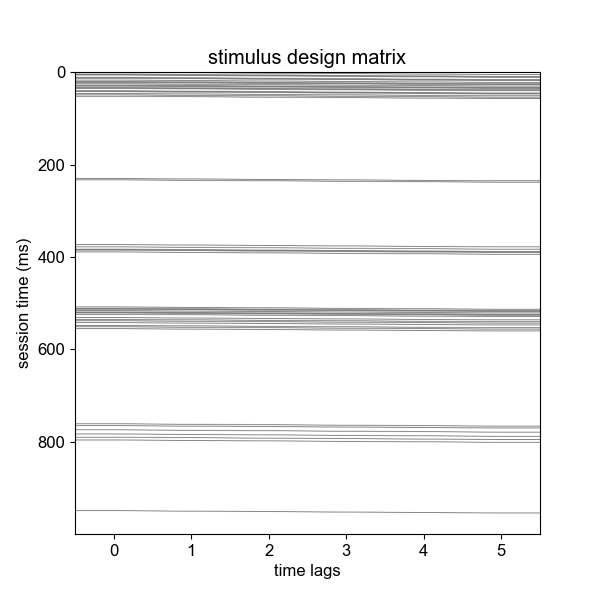

In [16]:
import os
from os.path import join as pjoin

save_dir = '/Users/gabriel/Library/CloudStorage/GoogleDrive-grojasbowe@gmail.com/My Drive/UCLA/ChurchlandLab/lab_meetings/20250417/figures'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.figure(figsize=(6, 6))
plt.imshow(design_matrix[0:1000, :], aspect='auto', cmap='gray_r')
plt.xlabel('time lags')
plt.ylabel('session time (ms)')
plt.title('stimulus design matrix')
# plt.savefig(pjoin(save_dir, "stimulus_design_matrix.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.show()

### Fit a linear model for the population

best model performance: 0.01


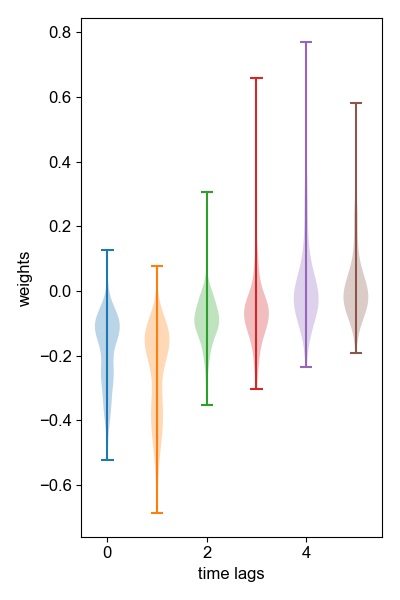

In [5]:
from sklearn.model_selection import KFold
from spks.utils import alpha_function
t_decay = 0.025
t_rise = 0.001
decay = t_decay / bin_size
kern = alpha_function(int(decay * 15), t_rise=t_rise, t_decay=decay, srate=1./bin_size)

smoothed_binned_spike_rate = np.zeros_like(binned_spike_rate)
for unit_idx in range(n_units):
    unit_spikes = binned_spike_rate[:, unit_idx]
    smoothed_binned_spike_rate[:, unit_idx] = np.convolve(unit_spikes, kern, mode='same')

X = design_matrix
y = smoothed_binned_spike_rate
y = (y - y.mean(axis=0, keepdims=True)) / y.std(axis=0, keepdims=True) # z-score the response matrix

n_folds = 10
kf = KFold(n_splits = n_folds, shuffle = True)

models = []
models_shuffle = []
cv_R_squared = []
cv_R_squared_shuffle = []

for i, (train_index, test_index) in enumerate(kf.split(X = X, y = y)): 
    X_train, X_test = X[train_index], X[test_index]
    X_train_shuffled = X_train[np.random.permutation(X_train.shape[0]),:]
    y_train, y_test = y[train_index], y[test_index]

    models.append(LinearRegression(fit_intercept=True).fit(X=X_train, y=y_train))
    models_shuffle.append(LinearRegression(fit_intercept=True).fit(X=X_train_shuffled, y=y_train))
    cv_R_squared.append(models[-1].score(X_test, y_test))  
    cv_R_squared_shuffle.append(models_shuffle[-1].score(X_test, y_test))

best_model = np.where(np.array(cv_R_squared) == np.max(cv_R_squared))[0][0]

print(f"best model performance: {np.round(cv_R_squared[best_model], 2)}")

unit_weights = models[best_model].coef_
plt.figure(figsize=(4, 6))
for timepoint in range(unit_weights.shape[1]):
    plt.violinplot(unit_weights[:, timepoint], positions=[timepoint])
plt.xlabel('time lags')
plt.ylabel('weights')
plt.tight_layout()

/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_1648/3473410428.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


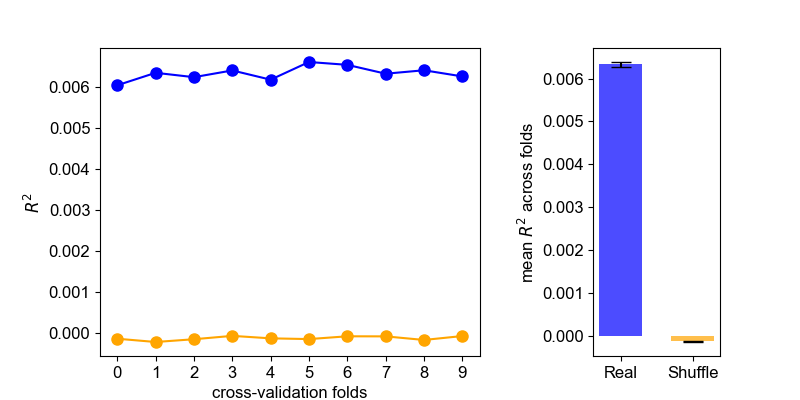

In [6]:
from scipy import stats

# Plot the R² per fold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.45})

# Line plot showing R² across folds
ax1.plot(cv_R_squared, 'o-', label='real', color='blue', markersize=8)
ax1.plot(np.array(cv_R_squared_shuffle), 'o-', label='shuffle', color='orange', markersize=8)
ax1.set_ylabel('$R^2$')
ax1.set_xlabel('cross-validation folds')
ax1.set_xticks(np.arange(0, n_folds))

# Bar plot showing mean R² values
bar_positions = [0, 1]
bar_heights = [np.mean(cv_R_squared), np.mean(cv_R_squared_shuffle)]
bar_errors = [stats.sem(cv_R_squared), stats.sem(cv_R_squared_shuffle)]

bars = ax2.bar(bar_positions, bar_heights, yerr=bar_errors, width=0.6, 
    color=['blue', 'orange'], capsize=7, alpha=0.7)
ax2.set_xticks(bar_positions)
ax2.set_xticklabels(['Real', 'Shuffle'])
ax2.set_ylabel('mean $R^2$ across folds')

plt.tight_layout()
# plt.savefig(pjoin(save_dir, "movement_stimulus_model_scores_across_folds.svg"), format='svg', dpi=300, bbox_inches='tight')


### Fitting a model for every unit independently

In [7]:
# from sklearn.model_selection import KFold
# from spks.utils import alpha_function
# binsize = bin_size
# t_decay = 0.025
# t_rise = 0.001
# decay = t_decay / binsize
# kern = alpha_function(int(decay * 15), t_rise=t_rise, t_decay=decay, srate=1./binsize)

# smoothed_binned_spike_rate = np.zeros_like(binned_spike_rate)
# for unit_idx in range(n_units):
#     unit_spikes = binned_spike_rate[:, unit_idx]
#     smoothed_binned_spike_rate[:, unit_idx] = np.convolve(unit_spikes, kern, mode='same')

# X = design_matrix
# y = smoothed_binned_spike_rate
# y = (y - y.mean(axis=0, keepdims=True)) / y.std(axis=0, keepdims=True) # z-score the response matrix

n_folds = 10
kf = KFold(n_splits = n_folds, shuffle = True)

su_models = [] #su stands for single unit
su_models_shuffle = []
su_cv_R_squared = []
su_cv_R_squared_shuffle = []
su_best_model = []
su_best_model_shuffle = []
su_best_model = np.zeros((n_units))
su_best_model_shuffle = np.zeros((n_units))

for unit_idx in range(n_units):
    pop_models = []
    pop_models_shuffle = []
    pop_cv_R_squared = []
    pop_cv_R_squared_shuffle = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X = X, y = y)): 
        X_train, X_test = X[train_index], X[test_index]
        X_train_shuffled = X_train[np.random.permutation(X_train.shape[0]),:]
        y_train, y_test = y[train_index][:, unit_idx], y[test_index][:, unit_idx]

        pop_models.append(LinearRegression(fit_intercept=True).fit(X=X_train, y=y_train))
        pop_models_shuffle.append(LinearRegression(fit_intercept=True).fit(X=X_train_shuffled, y=y_train))
        pop_cv_R_squared.append(pop_models[-1].score(X_test, y_test))  
        pop_cv_R_squared_shuffle.append(pop_models_shuffle[-1].score(X_test, y_test))

    su_models.append(pop_models)
    su_models_shuffle.append(pop_models_shuffle)

    su_cv_R_squared.append(pop_cv_R_squared)
    su_cv_R_squared_shuffle.append(pop_cv_R_squared_shuffle)
    
    best_model = np.where(np.array(pop_cv_R_squared) == np.max(pop_cv_R_squared))[0][0]
    best_model_shuffle = np.where(np.array(pop_cv_R_squared_shuffle) == np.max(pop_cv_R_squared_shuffle))[0][0]

    su_best_model[unit_idx] = best_model
    su_best_model_shuffle[unit_idx] = best_model_shuffle

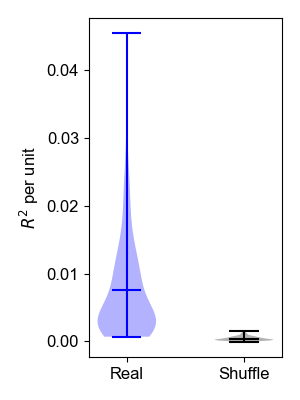

In [8]:
t = []
t_shuffle = []
for unit in range(n_units):
    t.append(su_cv_R_squared[unit][su_best_model[unit].astype(int)])
    t_shuffle.append(su_cv_R_squared_shuffle[unit][su_best_model_shuffle[unit].astype(int)])

fig, ax = plt.subplots(figsize=(3, 4))
parts = ax.violinplot([t, t_shuffle], showmeans=True, showextrema=True)

colors = ['b', 'k']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    
if 'cbars' in parts:
    parts['cbars'].set_color(colors)
if 'cmins' in parts:
    parts['cmins'].set_color(colors)
if 'cmaxes' in parts:
    parts['cmaxes'].set_color(colors)
if 'cmedians' in parts:
    parts['cmedians'].set_color(colors)
elif 'cmeans' in parts:
    parts['cmeans'].set_color(colors)

plt.xticks([1, 2], ['Real', 'Shuffle'])
plt.ylabel('$R^2$ per unit')
plt.tight_layout()

#### Plotting event-triggered avg PSTH

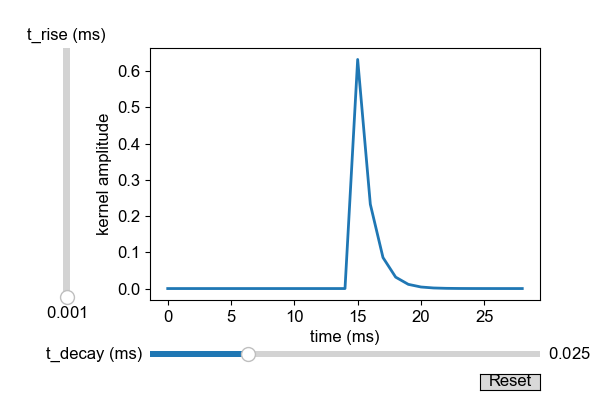

In [9]:
from matplotlib.widgets import Slider, Button

init_t_rise = 0.001
init_t_decay = 0.025
fixed_length = int((init_t_decay / bin_size) * 15)

def f(t_rise, t_decay):
    decay = t_decay / bin_size
    kern = alpha_function(fixed_length, t_rise=t_rise, t_decay=decay, srate=1./bin_size)
    return kern

fig, ax = plt.subplots(figsize=(6, 4))
line, = ax.plot(f(init_t_rise, init_t_decay), lw=2)
ax.set_xlabel('time (ms)')
ax.set_ylabel('kernel amplitude')

fig.subplots_adjust(left=0.25, bottom=0.25)

ax_t_rise = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
t_rise_slider = Slider(
    ax=ax_t_rise,
    label='t_rise (ms)',
    valmin=0,
    valmax=0.1,
    valinit=init_t_rise,
    orientation="vertical"
)

ax_t_decay = fig.add_axes([0.25, 0.1, 0.65, 0.03])
t_decay_slider = Slider(
    ax=ax_t_decay,
    label='t_decay (ms)',
    valmin=0,
    valmax=0.1,
    valinit=init_t_decay,
    orientation="horizontal"
)

def update(val):
    line.set_ydata(f(t_rise_slider.val, t_decay_slider.val))
    fig.canvas.draw_idle()

t_rise_slider.on_changed(update)
t_decay_slider.on_changed(update)

resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    t_rise_slider.reset()
    t_decay_slider.reset()
button.on_clicked(reset)

plt.show()

In [10]:
np.round(np.arange(0, post_seconds, 0.025), 3)[:-1]

array([0.   , 0.025, 0.05 , 0.075, 0.1  ])

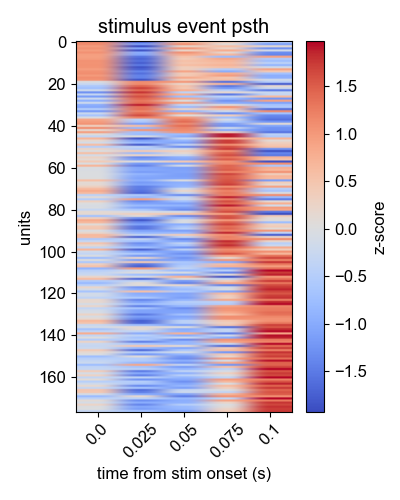

In [11]:
# Convolved with alpha function kernel
from spks.utils import alpha_function
binsize = bin_size
t_decay = 0.025
t_rise = 0.001
decay = t_decay / binsize
kern = alpha_function(int(decay * 15), t_rise=t_rise, t_decay=decay, srate=1./binsize)

pop_peth, timebin_edges, _ = population_peth(
        all_spike_times=spike_times_per_unit,
        alignment_times=all_stims,
        pre_seconds=0.025,
        post_seconds=post_seconds, #100 ms
        binwidth_ms=bin_size*1000, #25 ms
        pad=0.,
        kernel=kern
    )

mean_psth = np.mean(pop_peth, axis = 1)

from scipy.stats import zscore
normalized_mean_psth = zscore(mean_psth, axis=1, nan_policy='omit') #normalize each unit
peak_indices = np.argmax(normalized_mean_psth, axis=1)
peak_sort_indices = np.argsort(peak_indices) #row_sort_indices is for cumsum of model weights, peak_sort_indices is for earlier responses
sorted_psth = normalized_mean_psth[peak_sort_indices]


plt.figure(figsize=(4,5))
plt.imshow(sorted_psth, aspect='auto', cmap='coolwarm') # for sorting my model cumsum use `normalized_mean_psth[row_sort_indices]`
plt.colorbar(label = 'z-score')
plt.xticks(ticks = np.arange(0, sorted_psth.shape[1], 1), labels = np.round(np.arange(0, post_seconds, 0.025), 3)[:-1], rotation=45)
plt.xlabel('time from stim onset (s)')
plt.ylabel('units')
plt.title('stimulus event psth')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "peak_sort_stimulus_event_psth.png"), format='png', dpi=300, bbox_inches='tight')


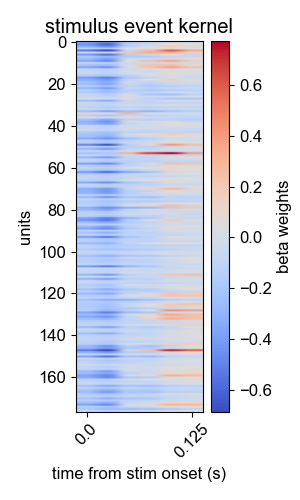

In [12]:
weights = models[np.where(np.array(cv_R_squared) == np.max(cv_R_squared))[0][0]].coef_

# row_cumsum = np.cumsum(weights[:,:n_timepoints], axis=1)
# row_sort_indices = np.argsort(row_cumsum[:, -1])[::-1]

plt.figure(figsize=(3, 5))
plt.imshow(weights[peak_sort_indices], aspect='auto', cmap='coolwarm')
plt.colorbar(label = 'beta weights')
plt.xticks(np.arange(0, n_timepoints, 5), (np.arange(0, n_timepoints, 5))*bin_size, rotation=45)
plt.xlabel('time from stim onset (s)')
plt.ylabel('units')
plt.title('stimulus event kernel')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "stimulus_event_kernel_weights.png"), format='png', dpi=300, bbox_inches='tight')

#### Visualizing single units and marking stimulus events

In [51]:
mask = np.logical_and(smoothed_binned_spike_rate[:, 25] > event_indices[0], smoothed_binned_spike_rate[:, 25] < event_indices[-1])
smoothed_binned_spike_rate[mask, 0].shape

(2209,)

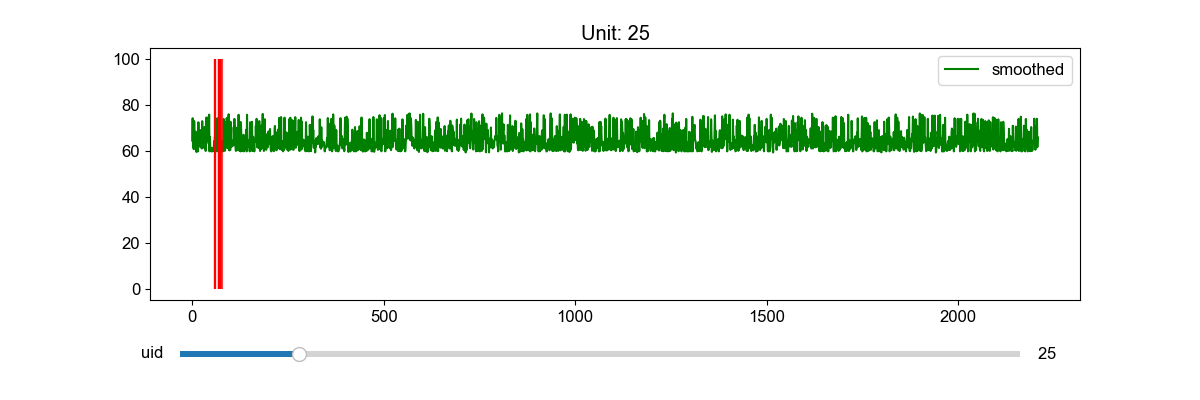

In [50]:
from matplotlib.widgets import Slider

emin = 50
emax = 80
# event_indices = np.searchsorted(time_bins[:-1], all_stims[emin:emax], side='right') - 1
event_indices = all_stims[emin:emax]


fig, ax = plt.subplots(figsize=(12, 4))
plt.subplots_adjust(bottom=0.25)

uid_init = 25
mask = np.logical_and(smoothed_binned_spike_rate[:, uid_init] > event_indices[0], smoothed_binned_spike_rate[:, uid_init] < event_indices[-1])
trace = smoothed_binned_spike_rate[mask, uid_init]
line, = ax.plot(trace, color='g', label='smoothed')
ax.vlines(event_indices[emin-emin:emax-emin], ymin=0, ymax=100, color='r', alpha=0.5)
ax.set_title(f'Unit: {uid_init}')
ax.legend()

ax_uid = plt.axes([0.15, 0.1, 0.7, 0.03])
uid_slider = Slider(ax_uid, 'uid', 0, binned_spike_rate.shape[1] - 1, valinit=uid_init, valstep=1)

def update(val):
    uid = int(uid_slider.val)
    mask = np.logical_and(smoothed_binned_spike_rate[:, uid] > event_indices[0], smoothed_binned_spike_rate[:, uid] < event_indices[-1])
    line.set_ydata(smoothed_binned_spike_rate[mask, uid])
    ax.set_title(f'Unit: {uid}')
    fig.canvas.draw_idle()

uid_slider.on_changed(update)
plt.show()


### Fitting a model with just stim activity

In [14]:
# def make_design_matrix(trial_ts, spike_times_per_unit, post_seconds, bin_size=0.025):
#     all_stims = np.hstack(np.array(trial_ts.stim_ts.dropna()))
#     start_time = all_stims[0]
#     end_time = all_stims[-1] + post_seconds
#     time_bins = np.arange(start_time, end_time + bin_size, bin_size)
#     combined_bins = np.union1d(time_bins, all_stims)
#     combined_bins.sort()
#     time_bins = combined_bins
    
#     n_units = len(spike_times_per_unit)
#     n_bins = len(time_bins) - 1
#     binned_spike_rate = np.zeros((n_bins, n_units))
#     for unit_idx, stimes in enumerate(spike_times_per_unit):
#         counts, _ = np.histogram(stimes, bins=time_bins)
#         binned_spike_rate[:, unit_idx] = counts / bin_size
    
#     stim_indicator = np.zeros(n_bins)
#     stim_indices = np.searchsorted(time_bins[:-1], all_stims, side='right') - 1
#     stim_indicator[stim_indices] = 1
    
#     tolerance = 1e-6
#     retrieved_stim_times = time_bins[stim_indices]
#     time_differences = all_stims - retrieved_stim_times
#     alignment_check = np.all(np.abs(time_differences) < tolerance)
    
#     if alignment_check:
#         n_timepoints = int(round(post_seconds / bin_size))
#         design_matrix = np.zeros((n_bins, n_timepoints))
#         for lag in range(n_timepoints):
#             if lag == 0:
#                 design_matrix[:, lag] = stim_indicator
#             else:
#                 design_matrix[lag:, lag] = stim_indicator[:-lag]
#         return design_matrix, binned_spike_rate, all_stims, n_timepoints, time_bins
#     else:
#         print("Alignment issue detected. Please check time_bins and stim_times.")
#         return None, None

# post_seconds = 0.150
# bin_size = 0.025
# design_matrix, binned_spike_rate, all_stims, n_timepoints, time_bins = make_design_matrix(trial_ts, spike_times_per_unit, post_seconds=post_seconds, bin_size=bin_size)
# n_samples = binned_spike_rate.shape[0]
# n_units = binned_spike_rate.shape[1]